# Part F(a) - Luenberger Observer for Linear Systems

In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

In [2]:
# 1. Define system parameters
M = 1000
mass_1 = 100
mass_2 = 100
length_1 = 20
length_2 = 10
g = 9.81

In [3]:
# Constructing state space matrices
A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, -(mass_1*g)/M, 0, -(mass_2*g)/M, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, -((M+mass_1)*g)/(M*length_1), 0, -(mass_2*g)/(M*length_1), 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, -(mass_1*g)/(M*length_2), 0, -(g*(M+mass_2))/(M*length_2), 0]])
B = np.array([[0], [1/M], [0], [1/(M*length_1)], [0], [1/(M*length_2)]])
D = np.zeros((1, 1))

In [4]:
# Setting LQR parameters
Q = np.diag([1000, 100, 1000, 1000, 100, 100])
R = np.array([[0.01]])
K, S, eigen_values = ctrl.lqr(A, B, Q, R)

In [5]:
# Define observer output matrices and corresponding L matrices
C_matrices = [np.array([[1, 0, 0, 0, 0, 0]]),  # Observing x component
              np.array([[1, 0, 0, 0, 0, 0], 
                        [0, 0, 0, 0, 1, 0]]), # Observing x and theta2
              np.array([[1, 0, 0, 0, 0, 0],     # Observing x, theta1 and theta2
                        [1, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0]])]

In [6]:
poles = -np.linspace(1, 6, 6)
L_matrices = [ctrl.place(A.T, C.T, poles).T for C in C_matrices]

In [7]:
# Setting initial conditions for the observer
initial_conditions = [10, 40, 10, 0, 60, 0, 0, 0, 0, 0, 0, 0]

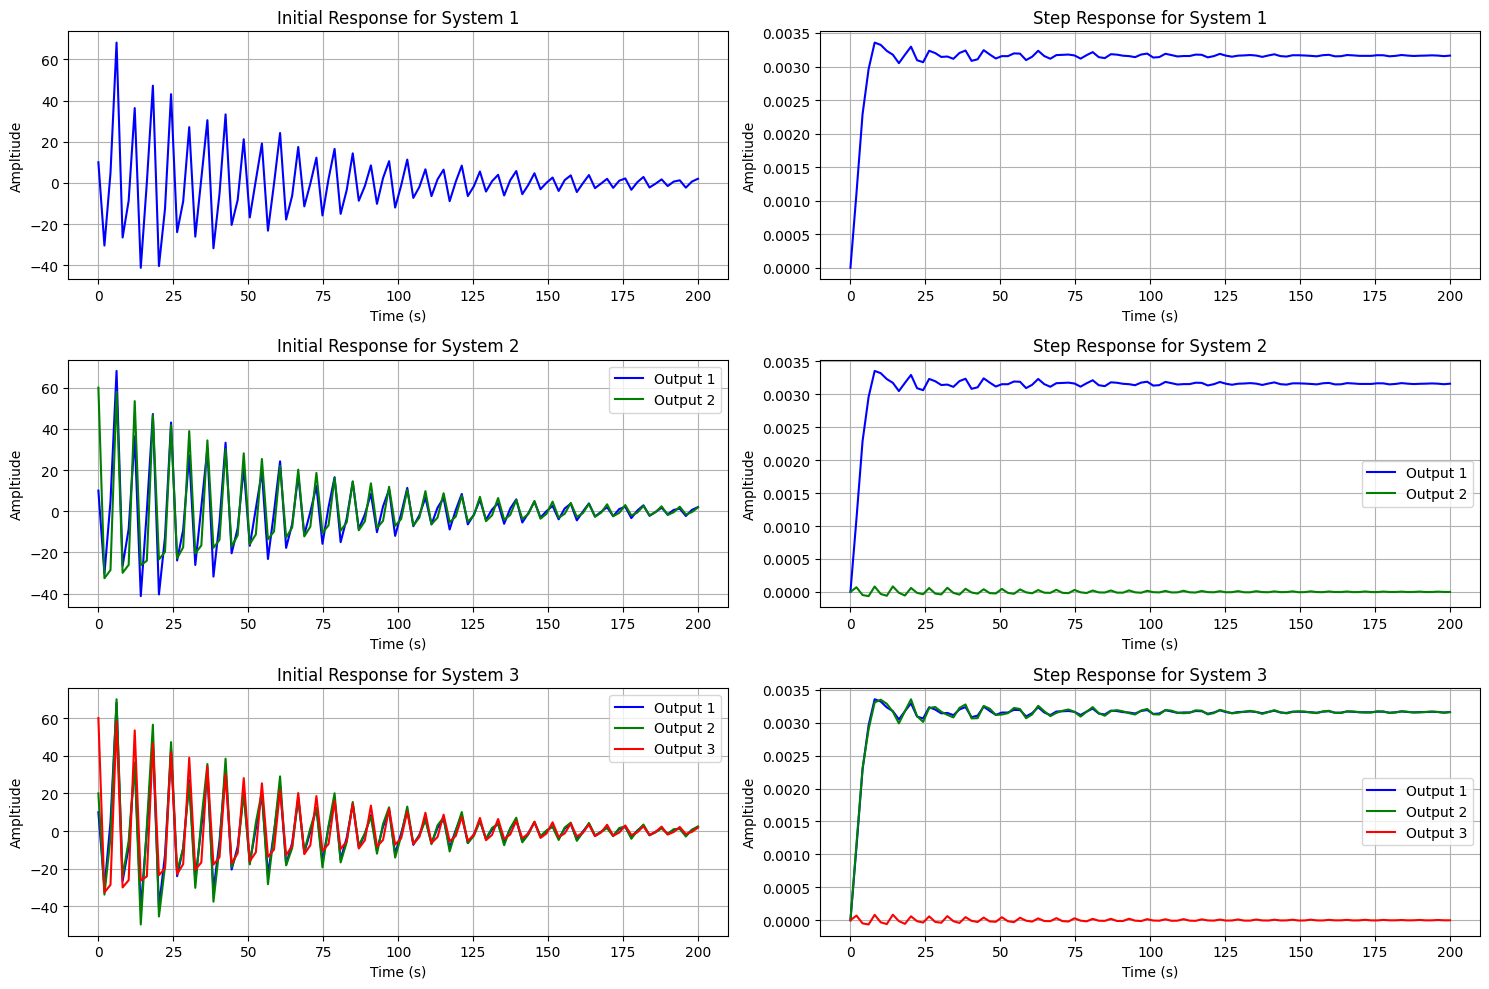

In [8]:
# Assign a color for each system
colors = ['b', 'g', 'r'] # Colors for plotting
# Construct and analyze each system
plt.figure(figsize=(15, 10))

for i, (C, L) in enumerate(zip(C_matrices, L_matrices)):
    A_q = np.block([[A - B @ K, B @ K], [np.zeros(A.shape), A - L @ C]])
    B_q = np.block([[B],[np.zeros(B.shape)]])
    C_q = np.block([C, np.zeros(C.shape)])
    D = np.zeros((C.shape[0], B.shape[1]))
    sys = ctrl.ss(A_q, B_q, C_q, D)

    # Plot initial response of the system
    plt.subplot(len(C_matrices), 2, 2*i + 1)
    T, yout = ctrl.initial_response(sys, T=np.linspace(0, 200, 100), X0=initial_conditions)
    yout = np.squeeze(yout)  # Ensure yout is a 1D array if it has only one output
    if yout.ndim == 1:
        plt.plot(T, yout, color=colors[i])
    else:
        for j in range(yout.shape[0]):
            plt.plot(T, yout[j, :], label=f'Output {j+1}', color=colors[j])
        plt.legend()
    plt.title(f'Initial Response for System {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Ampltiude')
    plt.grid(True)

    # Plot step response of the system
    plt.subplot(len(C_matrices), 2, 2*i + 2)
    T, yout = ctrl.step_response(sys, T=np.linspace(0, 200, 100))
    yout = np.squeeze(yout)  # Ensure yout is a 1D array if it has only one output
    if yout.ndim == 1:
        plt.plot(T, yout, color=colors[i])
    else:
        for j in range(yout.shape[0]):
            plt.plot(T, yout[j, :], label=f'Output {j+1}', color=colors[j])
        plt.legend()
    plt.title(f'Step Response for System {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Ampltiude')
    plt.grid(True)

plt.tight_layout()
plt.show()